## Implementing a student financial aid finder with Agentic Workflows
<link rel="stylesheet"
href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css"
integrity="sha384-JcKb8q3iqJ61gNV9KGb8thSsNjpSL0n8PARn9HuZOnIxN0hoP+VmmDGMN5t9UJ0Z"
crossorigin="anonymous">
<div class="bg-info">
<h3>What are agentic workflows?</h3>
</div>

An <b>agentic workflow</b> is a multi-step sequence of tasks or decisions whose orchestration is handled by AI agents. In Generative AI, AI agents are Large Language Models (or "Large Action Models" in this context) that can perform goal-oriented tasks with minimal human intervention. Such tasks may include everything from simple reasoning tasks to complex decision making, and often involve interaction with external resources or systems (called "tools").

The following will build an agentic workflow for finding scholarships and other student aid. The initial version of the workflow will consist of the following steps:


1.   A **screener** agent (LLM) builds a list of relevant questions for the interviewer to use to converse with the user.
2.   An **interviewer** agent (LLM) handles back-and-forth interaction with the user to gather enough information for the reporter agent. During each turn, it will narrow down relevant questions for the interview and iteratively feed them to the user. Once it thinks it has a complete user profile, it will end the interview and the reporter will be notified.
3.   A **reporter** agent (LLM + tool) receives notification from the interviewer agent that the interview has ended, then generates a personalized report containing student aid options that match the user's profile.



<div class="bg-info">
<h3>What is the difference between an agentic framework and an agentic orchestration framework?</h3>
</div>

There are different schools of thought about agentic orchestration frameworks.

Agentic orchestration can refer to <b>agent-of-agent</b> systems, which are defined based on the number of agents. In this case, they are simply agentic systems that consist of more than a single agent. Hence, it can refer to agentic systems with multiple agents; it can also refer to agentic systems that invoke other agentic systems.

Sometimes, agentic orchestration can also be used to distinguish complex multi-agent systems from simpler agentic systems. In this case, agentic orchestration is only necessary for systems with high levels of complexity. This is based on not just the number of agents, but other factors such as the types of flows (directed versus cyclic).

There are many frameworks that can be used for building agentic workflows. Due to their reasoning and decision-making abilities, LLMs are a natural fit for driving autonomous workflows. However, users often want the ability to extend, constrain or even override aspects of the flow. For example, they may need a way to dynamically limit cycles, manage state across disparate tools, or integrate human-in-the-loop fedback. A popular approach is to use <b>LLM orchestration</b> frameworks. These are frameworks that combine the flexible and dynamic capabilities of agent-driven workflows with low-level control over essential details of the orchestration. This notebook uses <b>LangChain</b> to build the AI agents, and <b>LangGraph</b> to build the agentic workflow that orchestrates the agents.

<div class="bg-info">
<h3>Workflow Summary</h3>
</div>

Steps of the Scholarship Finder:
- <i>Screener</i> builds a list of questions that will be used by the interviewer for the conversation with the user.
- <i>Interviewer</i> agent receives the user's student aid inquiry and uses it to initiate an interview with the user.
  - The interviewer extracts the latest user profile and uses it to analyze whether there is enough information to answer the interview questions.
      - If there is not enough information, the interviewer selects one of the questions to prompt to the user using an interrupt.
      - Else (i.e. there is enough information), the workflow redirects to the reporter agent.
- <i>Reporter</i> agent generates a personalized report of student aid that the user could qualify for.
  - The reporter uses its RAG tool to include a reference to a document in the data store for each student aid option.
  - The workflow ends.

# Setup

In [1]:
# Import libraries
from typing import TypedDict, Literal
import json
import random
from langgraph.graph import END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from langchain_core.messages import HumanMessage
import os
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import filter_messages
from langchain_openai import ChatOpenAI
import functools
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
import time
from ipywidgets import FileUpload, Button
from IPython.display import display
import codecs
import re
from vectordb_processor import VectorDbProcessor
import traceback

## Defining Templates
Each agent has its own specific **template**. The templates are defined here.

In [2]:
screener_template = """
Can you ask me some short questions that could be used to find out if I am highly likely to qualify for college financial aid, scholarships, grants and other student aid in this state?

Use intuitive, simple language. Explain the concepts as if I were new to them.

Try to stick to requirements that are as specific as possible to my background and this state.

Start with these lines: 
FROM SCREENER
*START QUESTIONS

End with this line:
*END QUESTIONS
"""

interviewer_template = """
You are a friendly interviewer. Please analyze the following questions to the best of your ability. 

For each question, if more information is needed to provide a definitive answer about college financial aid eligibility, say NOT_ENOUGH_INFO next to the question, 
but if no more information is needed to provide a definitive answer about college financial aid eligibility, 
say HAS_ENOUGH_INFO next to the question. Explain your answer. Try to use one sentence in your answers.

Use this format: 
FROM INTERVIEWER
1. NOT_ENOUGH_INFO: More information is necessary to determine your city of residence.
2. HAS_ENOUGH_INFO: It was explicitly stated that your GPA is 3.4.
"""

reporter_template = """
You are an intelligent analyst. Given the provided information, what is a list of student aid programs that I am likely to qualify for in this state? 

Where possible, for each student aid type in your answer, try to include the names of specific programs, institutions or organizations. 

If I am highly likely to qualify, say so, otherwise say that I am not likely to qualify. 

Start with this line: 
FROM REPORTER

When you're finished, say FINISHED.
"""

reporter_tool_prompt_template = """
Given this information, can you provide a list of relevant student aid programs that I am likely to qualify for in this state?

Include links.

Never suggest seeking information from elsewhere.

Provide links ONLY from your data, from the attached source file, if required, or if appropriate to the topic of the question.
"""

## Defining Utility Methods for Managing Questions
Here, we will define a class with utility methods that will be used by the user interface to iterate through the questions with the user.

In [3]:
#####################################
## UTILITY METHODS ##
#####################################

class QuestionUtilities:
    """
    Utility class for parsing and iterating through interview questions.
    """
    INTERVIEW_REGEX = r"_ENOUGH_INFO"
    ORIGINAL_QUESTIONS_REGEX = r"\*START QUESTIONS(.*?)\*END QUESTIONS"
    INCOMPLETE_QUESTIONS_REGEX = r"NOT_ENOUGH_INFO([^a-zA-Z]*)?(.*)?"
    COMPLETE_QUESTIONS_REGEX = r"HAS_ENOUGH_INFO([^a-zA-Z]*)?(.*)?"
    
    def __init__(self):
        """
        Initializes the question parser.
        """
        self.incomplete_questions = []

        self.complete_questions = []

        self.original_questions = ""

    def update_questions(self, questions: str = ""):

        if QuestionUtilities.INTERVIEW_REGEX in questions:
        
            self.incomplete_questions = self.initialize_questions(questions, QuestionUtilities.INCOMPLETE_QUESTIONS_REGEX)
            
            self.complete_questions = self.initialize_questions(questions, QuestionUtilities.COMPLETE_QUESTIONS_REGEX)

        else:

            self.original_questions = self.parse_questions(questions)
        
    def parse_questions(self, content: str) -> str:
        if content is None:
            return ""
            
        pattern = QuestionUtilities.ORIGINAL_QUESTIONS_REGEX
        
        match = re.search(pattern, content, re.DOTALL)
        
        return match.group(1).strip() if match else ""

    def initialize_questions(self, questions: str, pattern: str) -> str:
        if questions is None:
            return [] 
            
        original_questions = self.original_questions.split("\n")
        
        processed_questions = questions.split("\n")

        results = [(orig, re.findall(pattern, processed, re.DOTALL)) for orig, processed in zip(original_questions, processed_questions)]

        results = ["" if not processed else orig for orig, processed in results]

        results = list(filter(None, results))
        
        return results

    def is_in_interview_mode(self) -> int:
        return len(self.complete_questions) < len(self.incomplete_questions)
        
util = QuestionUtilities()

## Defining State
Here, we will define our **GraphState**, as well as the **nodes** and **edges** that our graph is comprised of. This will encapsulate **state** in our agentic workflows.

In [4]:
#####################################
## STATE ##
#####################################
class NMAgentState(TypedDict):
  """
  Encapsulates state in our agentic workflow
  """
  messages: Annotated[list, add_messages]

#####################################
## TOOLS ##
#####################################
processor = VectorDbProcessor(llm='granite-3-3-8b-instruct',
                              embed_model='nomic-embed-text-v1.5',
                              collection_name='scholarships',)

reporter_tool = create_retriever_tool(
    processor.vector_store.as_retriever(),
    "retrieve_document_links",
    reporter_tool_prompt_template,
) 
    
#####################################
## AGENTS ##
#####################################
"""
The LLMs used by the agents
"""
granite_llm = ChatOpenAI(temperature=0,
                         model="granite-3-3-8b-instruct",
                         request_timeout=240,
                         api_key=os.getenv('GRANITE_API_KEY'),
                         base_url=os.getenv('GRANITE_API_BASE'),
                        )

def create_agent(llm, tools, system_message: str, messages_key: str = None):
    """
    Creates an agent with the given LLM, tools, and system message
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name=messages_key or "messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

screener_agent = create_agent(granite_llm, [], screener_template)
interviewer_agent = create_agent(granite_llm, [], interviewer_template)
reporter_agent = create_agent(granite_llm, [], reporter_template)

#####################################
## NODES ##
#####################################
def agent_node(state, agent, name):
    """
    Creates an agent node
    """
    output = agent.invoke(state)
    
    results = [output]
    
    util.update_questions(output.content)
    
    if util.is_in_interview_mode() and util.incomplete_questions:
        
        question_response = interrupt(util.incomplete_questions)

        results += [HumanMessage(content=question_response)]
        
    return { "messages": results }

screener_node = functools.partial(agent_node, agent=screener_agent, name="Screener Agent")
interviewer_node = functools.partial(agent_node, agent=interviewer_agent, name="Interviewer Agent")
reporter_node = functools.partial(agent_node, agent=reporter_agent, name="Reporter Agent")
reporter_tool_node = ToolNode([reporter_tool])

#####################################
## CONDITIONAL EDGES ##
#####################################
def should_continue_interview(state) -> Literal['interviewer','reporter']:
    if util.is_in_interview_mode():
        return "interviewer"
    else:
        return "reporter"
    
def should_generate_report(state) -> Literal['reporter-tools', END]:
  if len(state['messages']) and 'tool_calls' in state['messages'][-1] and state['messages'][-1].tool_calls:
      return "reporter-tools"
  else:
      return END

Initializing OCR Processor...
Initializing splitter...
Initializing Vector DB/LLM settings...
Initializing settings for LLM model...
Initializing embedding model...
Initializing ChromaDb Client...
Initializing Vector Store...


## Defining the Workflow Graph
Here, we will define the workflow, which will encapsulate the state, nodes and edges defined above.

In [5]:
workflow = StateGraph(NMAgentState)

# nodes
workflow.add_node("screener", screener_node)
workflow.add_node("interviewer", interviewer_node)
workflow.add_node("reporter", reporter_node)
workflow.add_node("reporter-tools", reporter_tool_node)

# entrypoint
workflow.set_entry_point("screener")

# edges
workflow.add_edge("screener", "interviewer")
workflow.add_conditional_edges("interviewer", should_continue_interview)
workflow.add_conditional_edges("reporter", should_generate_report)
workflow.add_edge("reporter", END)
workflow.add_edge("reporter-tools", "reporter")

# compile the workflow into a graph
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

Visualize the graph:

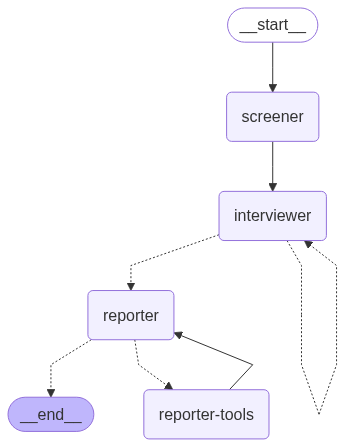

In [6]:
Image(graph.get_graph().draw_mermaid_png())

# Testing the workflow
Now that the workflow has been generated, we can test it out with different prompts.

In [7]:
# Prompt to test
input_text = f"""I live in Virginia."""

In [8]:
def run_stream(stream):
    try:
      for event in stream:
          if '__interrupt__' in event:
              questions = event['__interrupt__'][0].value
              input_text = ""
              for question in questions:
                  input_text = input_text + question + "\n " + input(question) + "\n"
              stream = graph.stream(Command(resume=input_text), config=graph.get_state(config).config, stream_mode="values")
              run_stream(stream)
              continue
          else:
              last_message = event['messages'][-1]
              last_message.pretty_print()
    except Exception as e:
      print(f"\n\nErrors generating response:\n===============\n {str(e)}")
      traceback.print_exc()

config = {"configurable": {"thread_id": 42, "recursion_limit": 5}}
stream = graph.stream({"messages": [HumanMessage(content=input_text)]}, config, stream_mode="values")
run_stream(stream)

================================ Human Message =================================

I live in Virginia.
================================== Ai Message ==================================

FROM SCREENER
*START QUESTIONS

1. Are you a U.S. citizen or eligible non-citizen?
2. Do you have a high school diploma or equivalent (GED)?
3. Are you planning to enroll in college or career school within the next academic year?
4. What is your family's annual income before taxes? (This will help determine your Expected Family Contribution (EFC) for financial aid.)
5. How many family members are currently living in your household?
6. How many of those family members will be attending college in the fall?
7. Does your family receive any federal assistance programs, such as Temporary Assistance for Needy Families (TANF), Supplemental Security Income (SSI), or food assistance?
8. Have you or your parents served in the U.S. Armed Forces? If yes, please specify.
9. Are you pursuing a degree or certificate pro

2. Do you have a high school diploma or equivalent (GED)? yes
3. Are you planning to enroll in college or career school within the next academic year? no, planning to enrol in 2028
4. What is your family's annual income before taxes? (This will help determine your Expected Family Contribution (EFC) for financial aid.) $140000
6. How many of those family members will be attending college in the fall? 0
7. Does your family receive any federal assistance programs, such as Temporary Assistance for Needy Families (TANF), Supplemental Security Income (SSI), or food assistance? no
8. Have you or your parents served in the U.S. Armed Forces? If yes, please specify. no
9. Are you pursuing a degree or certificate program at a participating Virginia institution? (This is important for state-specific aid programs.) I plan to attend Virginia State University
10. Have you or your parents lived in Virginia for at least one year prior to filing the FAFSA? yes


================================== Ai Message ==================================

FROM SCREENER
*START QUESTIONS

1. Are you a U.S. citizen or eligible non-citizen?
2. Do you have a high school diploma or equivalent (GED)?
3. Are you planning to enroll in college or career school within the next academic year?
4. What is your family's annual income before taxes? (This will help determine your Expected Family Contribution (EFC) for financial aid.)
5. How many family members are currently living in your household?
6. How many of those family members will be attending college in the fall?
7. Does your family receive any federal assistance programs, such as Temporary Assistance for Needy Families (TANF), Supplemental Security Income (SSI), or food assistance?
8. Have you or your parents served in the U.S. Armed Forces? If yes, please specify.
9. Are you pursuing a degree or certificate program at a participating Virginia institution? (This is important for state-specific aid programs.)
10.